# Question 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

%matplotlib inline

In [2]:
dataset = pd.read_csv('Tahoe_Healthcare_Data.csv')
X = dataset.iloc[:,0:6]
y = dataset['readmit30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 321)

## Logistic Regression

In [26]:
#Logistic Regression
penalty = ['l1']
C = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 100, 1000]
param_grid = {'penalty':penalty, 'C':C}
scoring = 'accuracy'

logistic_model = LogisticRegression(random_state = 123)

grid_lr = GridSearchCV(cv=5, estimator=logistic_model, 
                       param_grid=param_grid, scoring= scoring)
grid_lr.fit(X, y)

print("Best Accuracy: %f using %s" %(grid_lr.best_score_, 
                                     grid_lr.best_params_))
LR_tuned_model = grid_lr.best_estimator_
LR_tuned_model.fit(X_train, y_train)

Best Accuracy: 0.803743 using {'C': 0.1, 'penalty': 'l1'}


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
y_pred = LR_tuned_model.predict(X_test)
y_proba = LR_tuned_model.predict_proba(X_test)

LR_fpr, LR_tpr, _ = roc_curve(y_true= y_test, y_score=y_proba[:, 1])
LR_roc_auc = auc(LR_fpr, LR_tpr)

## CART

In [28]:
#CART
class_weight_set = [None, 'balanced']
max_depth_set = [3, 4, 5, 6, 7, 8, 9, 10]
params = {'max_depth':max_depth_set, 'class_weight':class_weight_set}
scoring = 'accuracy'

CART= DecisionTreeClassifier(random_state = 123)

grid_cart = GridSearchCV(cv=5, estimator=CART, 
                         param_grid=params, scoring=scoring)
grid_cart.fit(X_train, y_train)

print("Best Accuracy: %f using %s" %(grid_cart.best_score_, 
                                     grid_cart.best_params_))
CART_tuned_model = grid_cart.best_estimator_
CART_tuned_model.fit(X_train, y_train)

Best Accuracy: 0.792582 using {'class_weight': None, 'max_depth': 4}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [29]:
y_pred = CART_tuned_model.predict(X_test)
y_proba = CART_tuned_model.predict_proba(X_test)

CART_fpr, CART_tpr, _ = roc_curve(y_true= y_test, 
                                  y_score=y_proba[:, 1])
CART_roc_auc = auc(CART_fpr, CART_tpr)

## Random Forest

In [3]:
# RF
#n_estimators_set = [100, 300, 500, 700, 900]
#max_features_set = ['auto',1, 2, 3, 4, 5, 6]
#min_samples_split_set = [2, 5, 10]
#min_samples_leaf_set = [1, 2, 4]
#max_depth_set = [5, 10, 20, 30]
n_estimators_set = [900]
max_features_set = [6]
max_depth_set = [5]


rf_models = dict()

scoring = 'accuracy'

for m in max_features_set:
    params = {'n_estimators':n_estimators_set,'max_depth': max_depth_set}
    RF = RandomForestClassifier(random_state = 123, max_features=m)
    grid_rf = GridSearchCV(cv = 5, estimator=RF, param_grid=params, 
                           scoring = scoring, n_jobs= -1)
    grid_rf.fit(X_train, y_train)
    rf_models[m] = grid_rf.best_estimator_
    print("Best Accuracy: %f with the number of features: %s" 
          %(grid_rf.best_score_,  m))
    
#RF_tuned_model = grid_rf.best_estimator_
#RF_tuned_model.fit(X_train, y_train)

Best Accuracy: 0.801712 with the number of features: 6


In [31]:
RF_tuned_model = rf_models[4] # best model at m = 4
RF_tuned_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [32]:
y_pred = RF_tuned_model.predict(X_test)
y_proba = RF_tuned_model.predict_proba(X_test)

RF_fpr, RF_tpr, _ = roc_curve(y_true=y_test,
                              y_score=y_proba[:, 1])
RF_roc_auc = auc(RF_fpr, RF_tpr)

## Bagging

In [4]:
#Bagging
#n_estimators_set = [100, 300, 500, 700, 900, 1100, 1300]
#max_features_set = [1, 2, 3, 4, 5, 6]
n_estimators_set = [900]
max_features_set = [6]
scoring = 'accuracy'

params_set = {'n_estimators':n_estimators_set, 
              'max_features':max_features_set}

cart = DecisionTreeClassifier(random_state=123, max_depth= 5)
Bagging = BaggingClassifier(base_estimator=cart)

grid_bagging= GridSearchCV(cv=5, estimator=Bagging, param_grid = params_set, 
                           scoring=scoring, n_jobs=-1)
grid_bagging.fit(X_train, y_train)

print("Best Accuracy: %f using %s" %(grid_bagging.best_score_, 
                                     grid_bagging.best_params_))
Bagging_tuned_model = grid_bagging.best_estimator_
Bagging_tuned_model.fit(X_train, y_train)

Best Accuracy: 0.798859 using {'max_features': 6, 'n_estimators': 900}


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=6,
         max_samples=1.0, n_estimators=900, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [34]:
y_pred = Bagging_tuned_model.predict(X_test)
y_proba = Bagging_tuned_model.predict_proba(X_test)

Bagging_fpr, Bagging_tpr, _ = roc_curve(y_score=y_proba[:, 1], 
                                        y_true=y_test)
Bagging_roc_auc = auc(Bagging_fpr, Bagging_tpr)

## Model Comparison in Area Under Curve

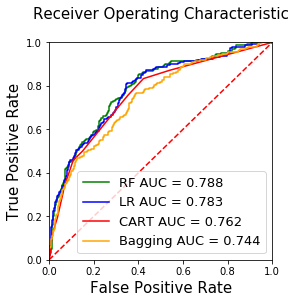

Area under Curve(AUC) in the testset

Random Forest : 0.788 using the number of features: 4
Logistic Regression : 0.783 using {'C': 0.1, 'penalty': 'l1'}
Decision Tree : 0.762 using {'class_weight': None, 'max_depth': 4}
Bagging : 0.744 using {'max_features': 4, 'n_estimators': 1100}


In [36]:
plt.rcParams['figure.figsize'] = (4, 4)
plt.title('Receiver Operating Characteristic\n', fontsize = 15)
plt.plot(RF_fpr, RF_tpr, 'g', label = 'RF AUC = %0.3f' % RF_roc_auc)
plt.plot(LR_fpr, LR_tpr, 'b', label = 'LR AUC = %0.3f' % LR_roc_auc)
plt.plot(CART_fpr, CART_tpr, 'r', label = 'CART AUC = %0.3f' % CART_roc_auc)
plt.plot(Bagging_fpr, Bagging_tpr, 'orange', label = 'Bagging AUC = %0.3f' %Bagging_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize =15)
plt.xlabel('False Positive Rate', fontsize = 15)
#plt.text(x = 0.41, y = 0.28, s='Logistic AUC = 0.79', fontsize = 15, color = 'b')
#plt.text(x = 0.4, y = 0.2, s='Severity AUC = 0.66', fontsize = 15, color = 'g')
plt.legend(fontsize = 13, loc = 'lower right')
plt.savefig('ROC_curve.png', bbox_inches='tight')
plt.show()
print("Area under Curve(AUC) in the testset\n")
print("Random Forest : %0.3f using the number of features: 4" %(RF_roc_auc))
print("Logistic Regression : %0.3f using %s" %(LR_roc_auc, grid_lr.best_params_))
print("Decision Tree : %0.3f using %s" %(CART_roc_auc, grid_cart.best_params_))
print("Bagging : %0.3f using %s" %(Bagging_roc_auc, grid_bagging.best_params_))

To find out the best classifier in the five fold cross-validation method, the grid search has been applied to optimise the parameters as above. As a result, by changing the seed, there are many turnovers between the random forest and logistic regression in terms of the area under curve. Although it is arduous to point out the best model among the four classifiers, there is a certain tendency that the random forest and logistic regression always perform better than the deicision tree and bagging models. The best number of the features on the random forest is 4 with the 900 estimator, which gives the best AUC of 0.788. In addition, the logistic regression has the best outcome applied by the lasso regression with lambda of 0.1. Overall, considering that the grid search for the random forest is required to make use of a lot more expensive computation than the other models, the logistic regression classifier is a better option to use for saving the cost in terms of time-efficiency. 